In [1]:
# Import libraries
# import cvxpy as cp
from cplex import Cplex, CplexError
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Strategies
 For strategies 3 and 4 include mathematical formulation of optimization problem in report and/or in notebook

In [2]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices, counter):
   x_optimal = x_init
   cash_optimal = cash_init
   weights = x_optimal * cur_prices / (np.sum(x_init * cur_prices))
   return x_optimal, cash_optimal, weights

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices, counter):
    fee_rate = 0.005  # Transaction fee rate
    # Compute total portfolio value (current holdings + free cash)
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Initially, set the target weights equally
    w = 1 / N
    
    # Initialize variables for iteration
    iteration = 0
    max_iterations = 100  # Prevent infinite loop
    cash_optimal = cash_init
    x_optimal = np.copy(x_init)
    # reweight_counter = 0 # Optional counter to see how many times reweighting occurs due to transaction costs.
    
    while iteration < max_iterations:
        iteration += 1
        # Compute target cash allocation for each asset
        cash_distribution = current_value * w
        # Calculate the target number of shares, rounding down
        x_target = np.floor(cash_distribution / cur_prices).astype(int)
        # Calculate the total cost considering buying/selling shares & transaction fees
        transaction_costs = np.sum(np.abs(x_target - x_optimal) * cur_prices) * fee_rate
        # Calculate cash required for rebalancing to target allocation including transaction costs
        cash_required = np.sum((x_target - x_optimal) * cur_prices) + transaction_costs
        
        if cash_required <= cash_optimal:
            # If enough cash is available, finalize the optimal allocation
            x_optimal = x_target
            cash_optimal -= cash_required  # Update remaining free cash after transactions
            break
        else:
            # reweight_counter += 1
            # Not enough cash, adjust target weights proportionally and retry
            adjustment_factor = cash_optimal / (cash_required + 1e-6)  # Add small value to avoid division by zero
            w *= adjustment_factor  # Adjust weights down to fit the budget
    
    if iteration == max_iterations:
        print("Max iterations reached, solution may not be optimal.")
    
    # Recompute the final cash optimal to account for rounding of shares
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    w = x_optimal * cur_prices / (current_value - cash_optimal)
    
    return x_optimal, cash_optimal, w

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices, counter):
    # Compute total portfolio value (current holdings + free cash)
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Create an instance of a model
    mdl = Model('MinVariancePortfolio')
    
    # Decision variables for asset weights
    y = mdl.continuous_var_list(N, name='y')
    
    # Objective function: Minimize the portfolio variance
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Constraints
    # Sum of y (weights) equals 1 (100% of the portfolio)
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == 1)
    # Non-negativity constraints on weights
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    
    # Solve the problem
    solution = mdl.solve(log_output=False)
    if solution:
        y_values = np.array([y[i].solution_value for i in range(N)])
        x_optimal = np.floor(y_values * current_value / cur_prices).astype(int)
    else:
        raise Exception("Problem is infeasible or unbounded.")

    # Calculate leftover free cash
    available_cash = current_value - np.sum(x_optimal * cur_prices)

    # Check and adjust for transaction fees using 'adjust_portfolio_for_fees'
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    # Re-adjust leftover cash
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, counter):

    # Risk free rate 2.5%
    rfr = 0.0025
    rfr = 0.0025/252 # I'm honestly not sure about dividing by 252 to make it daily return, but i think I'm supposed to
    current_value = np.sum(x_init * cur_prices) + cash_init # Current Portfolio Value + Free Cash
    
    # Create an instance of a model
    mdl = Model('MaxSharpeRatio')
    
    # Decision variables
    y = mdl.continuous_var_list(N, name='y')
    kappa = mdl.continuous_var(name='kappa', lb=0)
    
    # Objective function
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Constraints
    mdl.add_constraint(mdl.sum((mu[i] - rfr) * y[i] for i in range(N)) == 1)
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == kappa)
    
    # Solve the problem
    solution = mdl.solve(log_output=False)
    
    if solution:
        y_values = np.array([y[i].solution_value for i in range(N)])
        kappa_value = kappa.solution_value
        w_star = y_values / kappa_value # Get weights
        x_optimal = np.floor(w_star * current_value / cur_prices).astype(int) # Get optimal share distribution
    else:
        raise Exception("Problem is infeasible or unbounded.")
        
    available_cash = current_value - np.sum(x_optimal * cur_prices) # Calculate leftover Cash

    # Adjust for transaction fees (Same as min variance strat)
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    # Re-adjust leftover cash for transaction costs
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

In [6]:
def adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value):
    '''
    Function for adjusting the optimal portfolio selection by taking into account the transaction fee.
    Heuristic approach will check if the current approach is feasible (enough leftover cash for transaction costs), and
    if not feasible, it will reduce the weights by a common ratio (99%) before updating the purchasing numbers and recalculating 
    transaction fees and available cash. This loop continues until the available cash is greater than the transaction fees.
    '''
    # Calculate initial transaction fees
    transaction_volumes = np.abs(x_optimal - x_init) * cur_prices
    initial_fees = np.sum(transaction_volumes) * fee_rate
    
    # Check if rebalancing is feasible within available cash
    if initial_fees <= available_cash:
        return x_optimal  # No adjustment needed
        
    portfolio_value = current_value - available_cash # allocated cash to portfolio
    # Adjust portfolio weights
    while available_cash < initial_fees:
        
        # Get weights:
        weights = x_optimal * cur_prices / (current_value - available_cash) #Should sum to 1
        w_sum = round(np.sum(weights),5).astype(int)
        if w_sum != 1:
            raise ValueError(f"Sum of weights not equal to 1. Sum = {w_sum}")
            
        # Reduce weights by common factor (No longer adding to 100% of current value)
        weights *= 0.99 #reduce to 99% of current distribution
        # Get new stock distribution
        x_new = np.floor(weights * portfolio_value / cur_prices).astype(int)
        # Calculate new available cash
        new_available_cash = available_cash + np.sum(cur_prices * (x_optimal - x_new))
        # Calculate new transaction costs:
        new_transaction_fees = np.sum(np.abs(x_new - x_init) * cur_prices * fee_rate)

        # Update variables for next loop
        available_cash = new_available_cash
        transaction_fees = new_transaction_fees
        x_optimal = x_new
        
    weights = x_optimal * cur_prices / (current_value - available_cash)
    return x_optimal, weights # Return the last feasible adjustment

In [7]:
def strat_max_Sharpe_delayed(x_init, cash_init, mu, Q, cur_prices, counter):
    """ This is the exact same code as the max sharpe ratio above, the only difference is that we include a counter on the periods
    and we can pick during what periods we want to trade. To try and improve the code by decreasing transaction costs, we will only
    re-balance the weights every other re-balancing period.
    """
    # return initial portfolio if the counter is divisible by 2
    if counter%2 == 0:
        x_optimal = x_init
        cash_optimal = cash_init
        weights = x_optimal * cur_prices / (np.sum(x_init * cur_prices)) # get weights as fraction of portfolio value
        return x_optimal, cash_optimal, weights
        
    # Risk free rate 2.5%
    rfr = 0.0025
    rfr = 0.0025/252 # I'm honestly not sure about dividing by 252 to make it daily return, but i think I'm supposed to
    
    current_value = np.sum(x_init * cur_prices) + cash_init # Current Portfolio Value + Free Cash
    
    # Create an instance of a model
    mdl = Model('MaxSharpeRatio')
    
    # Decision variables
    y = mdl.continuous_var_list(N, name='y')
    kappa = mdl.continuous_var(name='kappa', lb=0)
    
    # Objective function
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Constraints
    mdl.add_constraint(mdl.sum((mu[i] - rfr) * y[i] for i in range(N)) == 1)
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == kappa)
    
    # Solve the problem
    solution = mdl.solve(log_output=False)
    
    if solution:
        y_values = np.array([y[i].solution_value for i in range(N)])
        kappa_value = kappa.solution_value
        w_star = y_values / kappa_value # Get weights
        x_optimal = np.floor(w_star * current_value / cur_prices).astype(int) # Get optimal share distribution
    else:
        raise Exception("Problem is infeasible or unbounded.")
        
    available_cash = current_value - np.sum(x_optimal * cur_prices) # Calculate leftover Cash

    # Adjust for transaction fees (Same as min variance strat)
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    # Re-adjust leftover cash for transaction costs
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

# Data loading and Initialization of Portfolios

In [8]:
# Input file
input_file_prices = 'ts2020_2021.csv' # path to ts2020_2021.csv file

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [9]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [10]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0) # Expected Return
Q = np.cov(cur_returns0.T) # Covariace matrix

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [11]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_max_Sharpe_delayed']
# strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Maximum Sharpe Ratio Delayed Portfolio']
# strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Maximum Sharpe Ratio Portfolio']

N_strat = 5  # comment this in your code
# N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_max_Sharpe_delayed ]



Initial portfolio value = $ 1000012.93



# Running Optimization and printing results

In [12]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Array for 
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Array for cash over all periods for eah strategy
end_dates = []
weights = np.zeros((N_strat, 12, 20)) #store weights
counter = 0

# Loop through periods beginning at 1
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   end_dates.append(dates[day_ind_end])
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]
          
      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weights[strategy, period-1,:] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, counter)
        
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
       
      ###################### Insert your code here ############################
      #Calculate net value:
      if (np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1]) > (np.dot(curr_positions,cur_prices) + curr_cash):
           raise ValueError("New strategy requires excess funds.")
      # Check that cash account is >= 0
      if cash[strategy, period-1] < 0:
           raise ValueError("Cash account must be non-negative.")
      # Check that we can buy new portfolio subject to transaction costs
      # I do this check in my as the last lines in my functions so that it get's added to 'cash[strategy, period-1]' above automatically, 
      # therefore this check is redundant as it would result in a negative cash statement, and then get caight by the above if statement.
    
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      # Increase counter
      counter+=1

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 995012.86, value end = $ 995012.86
  Strategy "Mininum Variance Portfolio", value begin = $ 992777.00, value end = $ 916377.98
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.51, value end = $ 922163.93
  Strategy "Maximum Sharpe Ratio Delayed Portfolio", value begin = $ 1000012.93, value end = $ 893956.75

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 990062.68, value end = $ 916799.02
  Strategy "Mininum Variance Portfolio", value begin = $ 955959.71, value end = $ 851310.05
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 961984.62, value end = $ 1017139.27
  Strategy "Maximum Sharpe Ratio Delayed Portfolio", value begin = $ 

# Plot Results

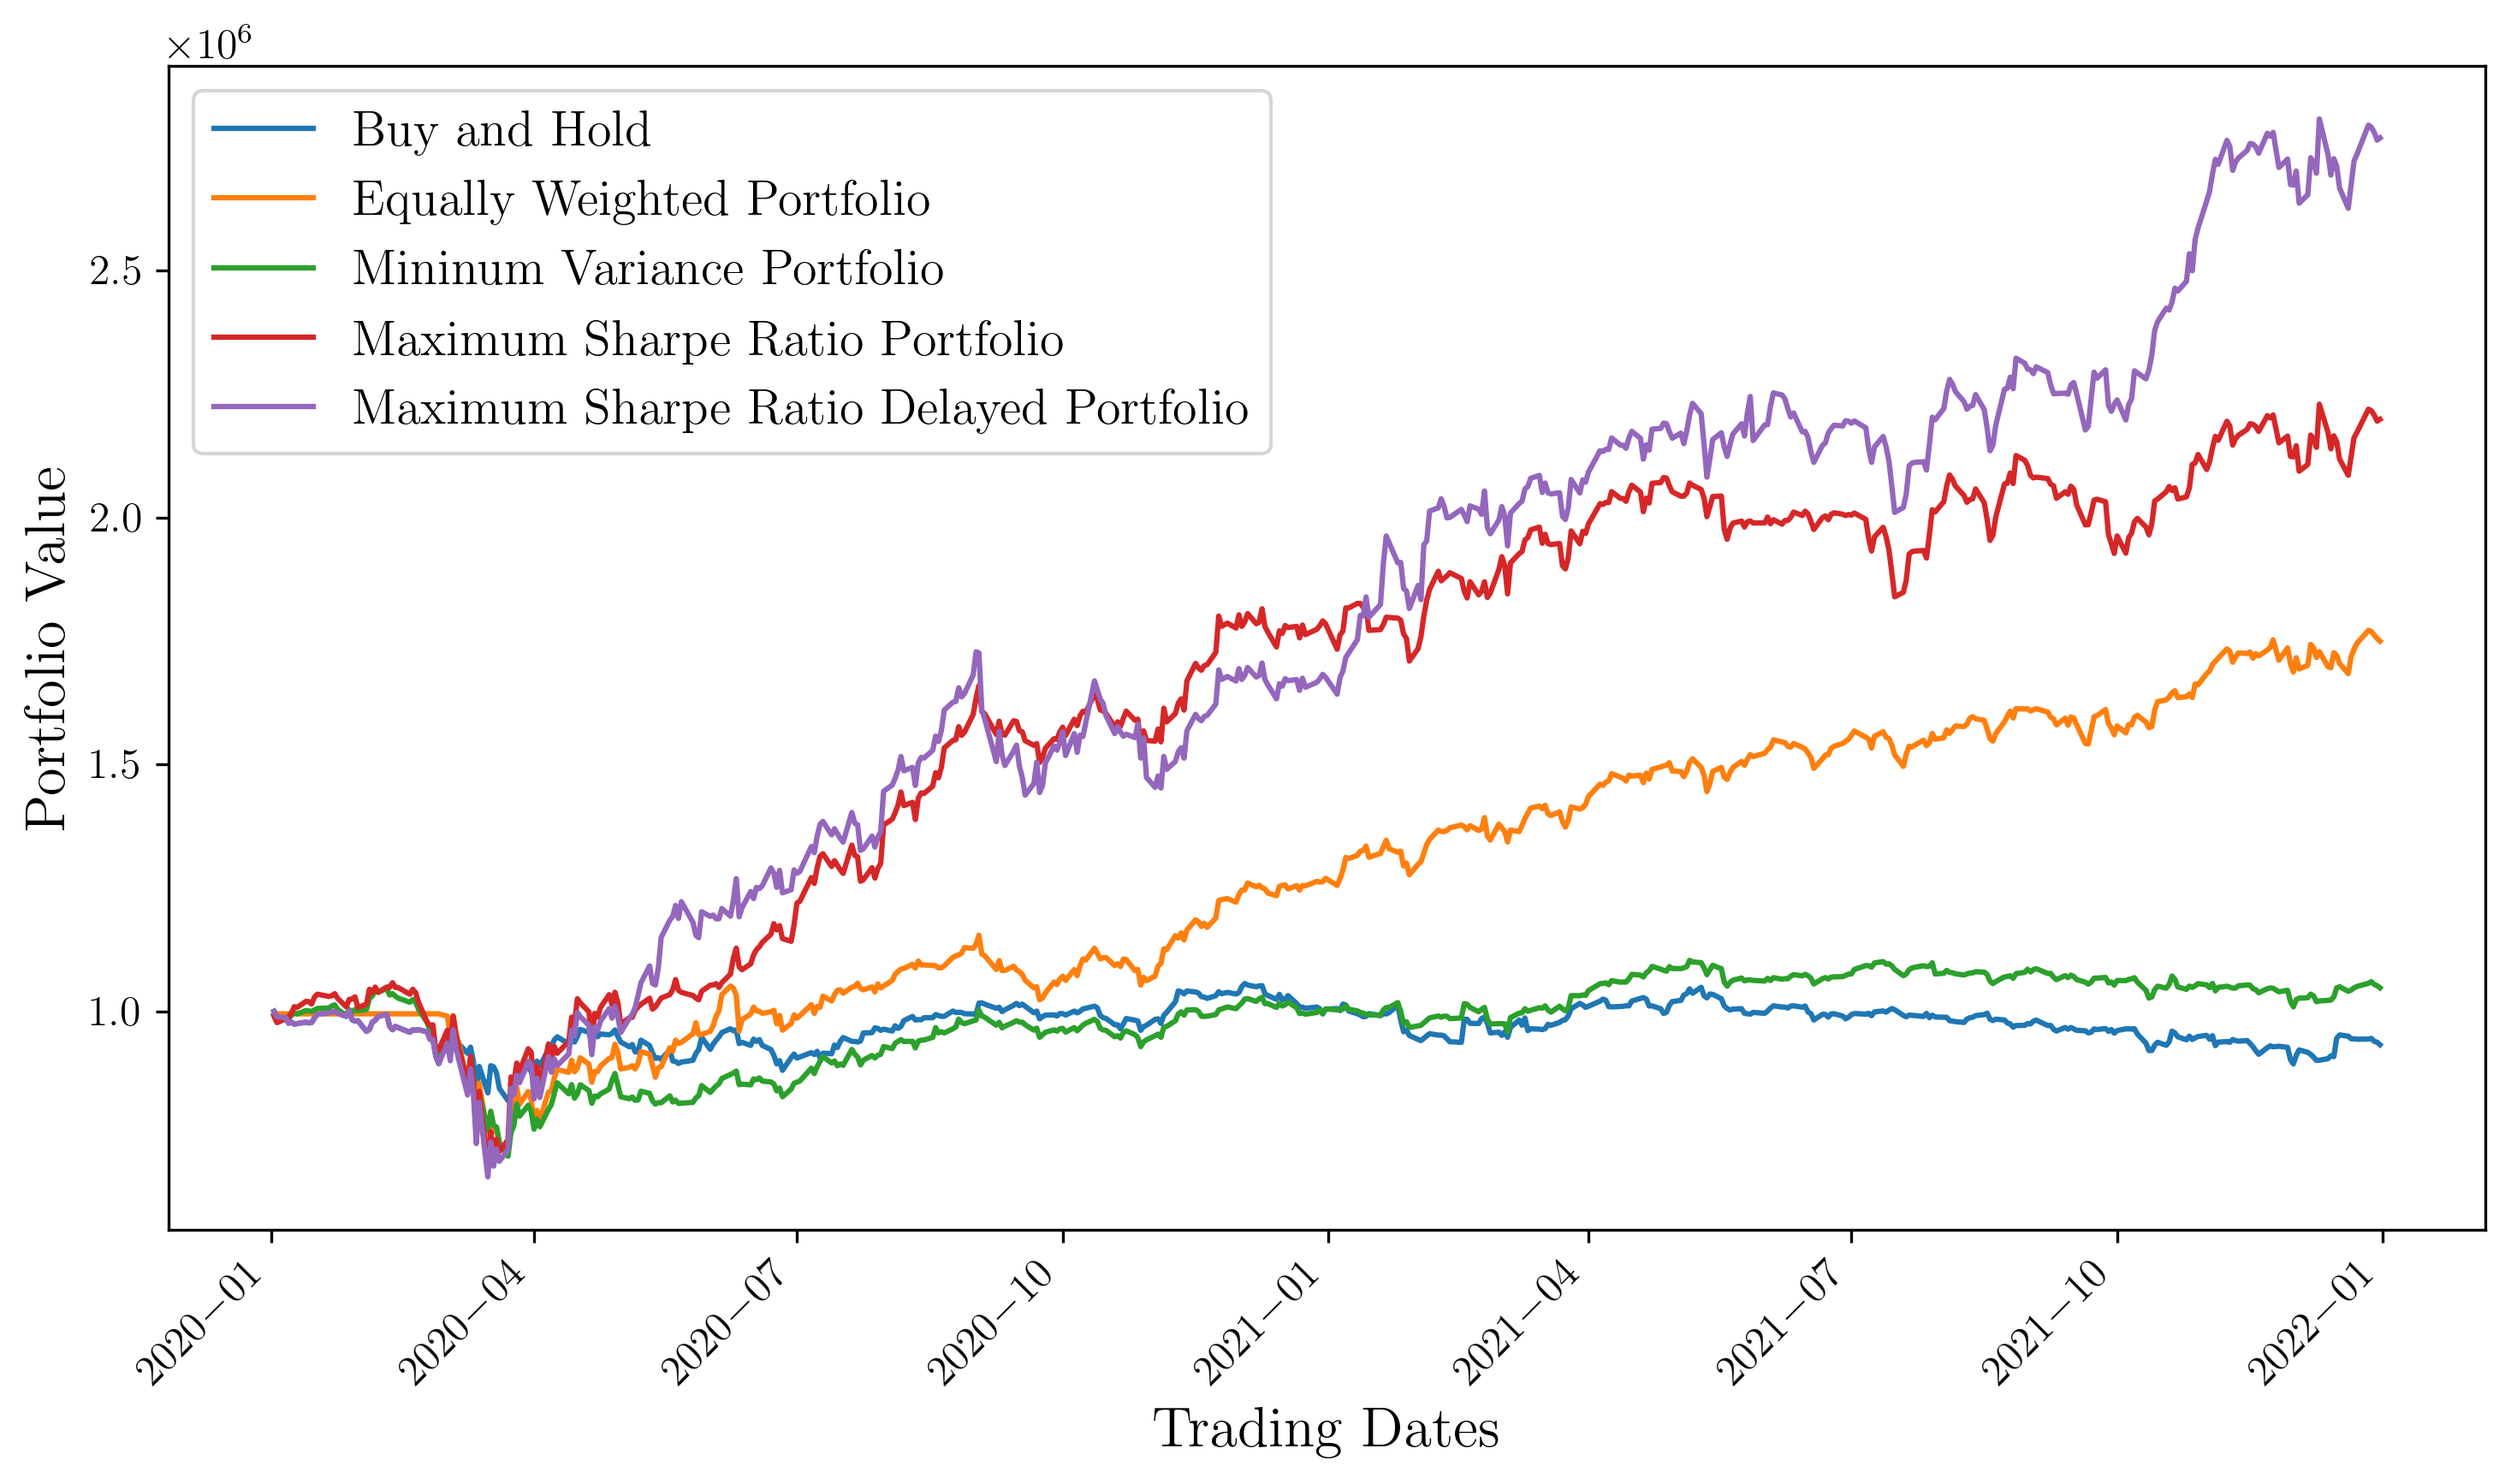

In [16]:
# # Plot results
###################### Insert your code here ############################
plt.rcParams.update({
    "font.size": 14,  # Adjusts the base/default font size
    "xtick.labelsize": 12,  # Adjusts x-axis tick label sizes
    "ytick.labelsize": 12,  # Adjusts y-axis tick label sizes
    "text.usetex": True,  
    "font.family": "serif"
})

dates = pd.to_datetime(dates) 
# Set the figure size and dpi
fig, axs = plt.subplots(figsize=(10, 6), dpi=300)
for i in range(N_strat):
    # Plot
    axs.plot(dates, portf_value[i], label=strategy_names[i])
axs.legend(fontsize=14)
plt.xlabel("Trading Dates", fontsize=16)
plt.ylabel("Portfolio Value", fontsize=16)

# Rotate date labels for better readability
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45, ha="right")

# Specify the directory and filename where you want to save the figure
directory = '/Users/declanbracken/Development/UofT_Projects/MIE_1624/A1/Graphs/'
filename = 'YearsCodingVSalary.png'
full_path = directory + filename
plt.tight_layout()
# Save the figure
# plt.savefig(full_path)
# plt.close()  # Close the figure after saving to free up memory


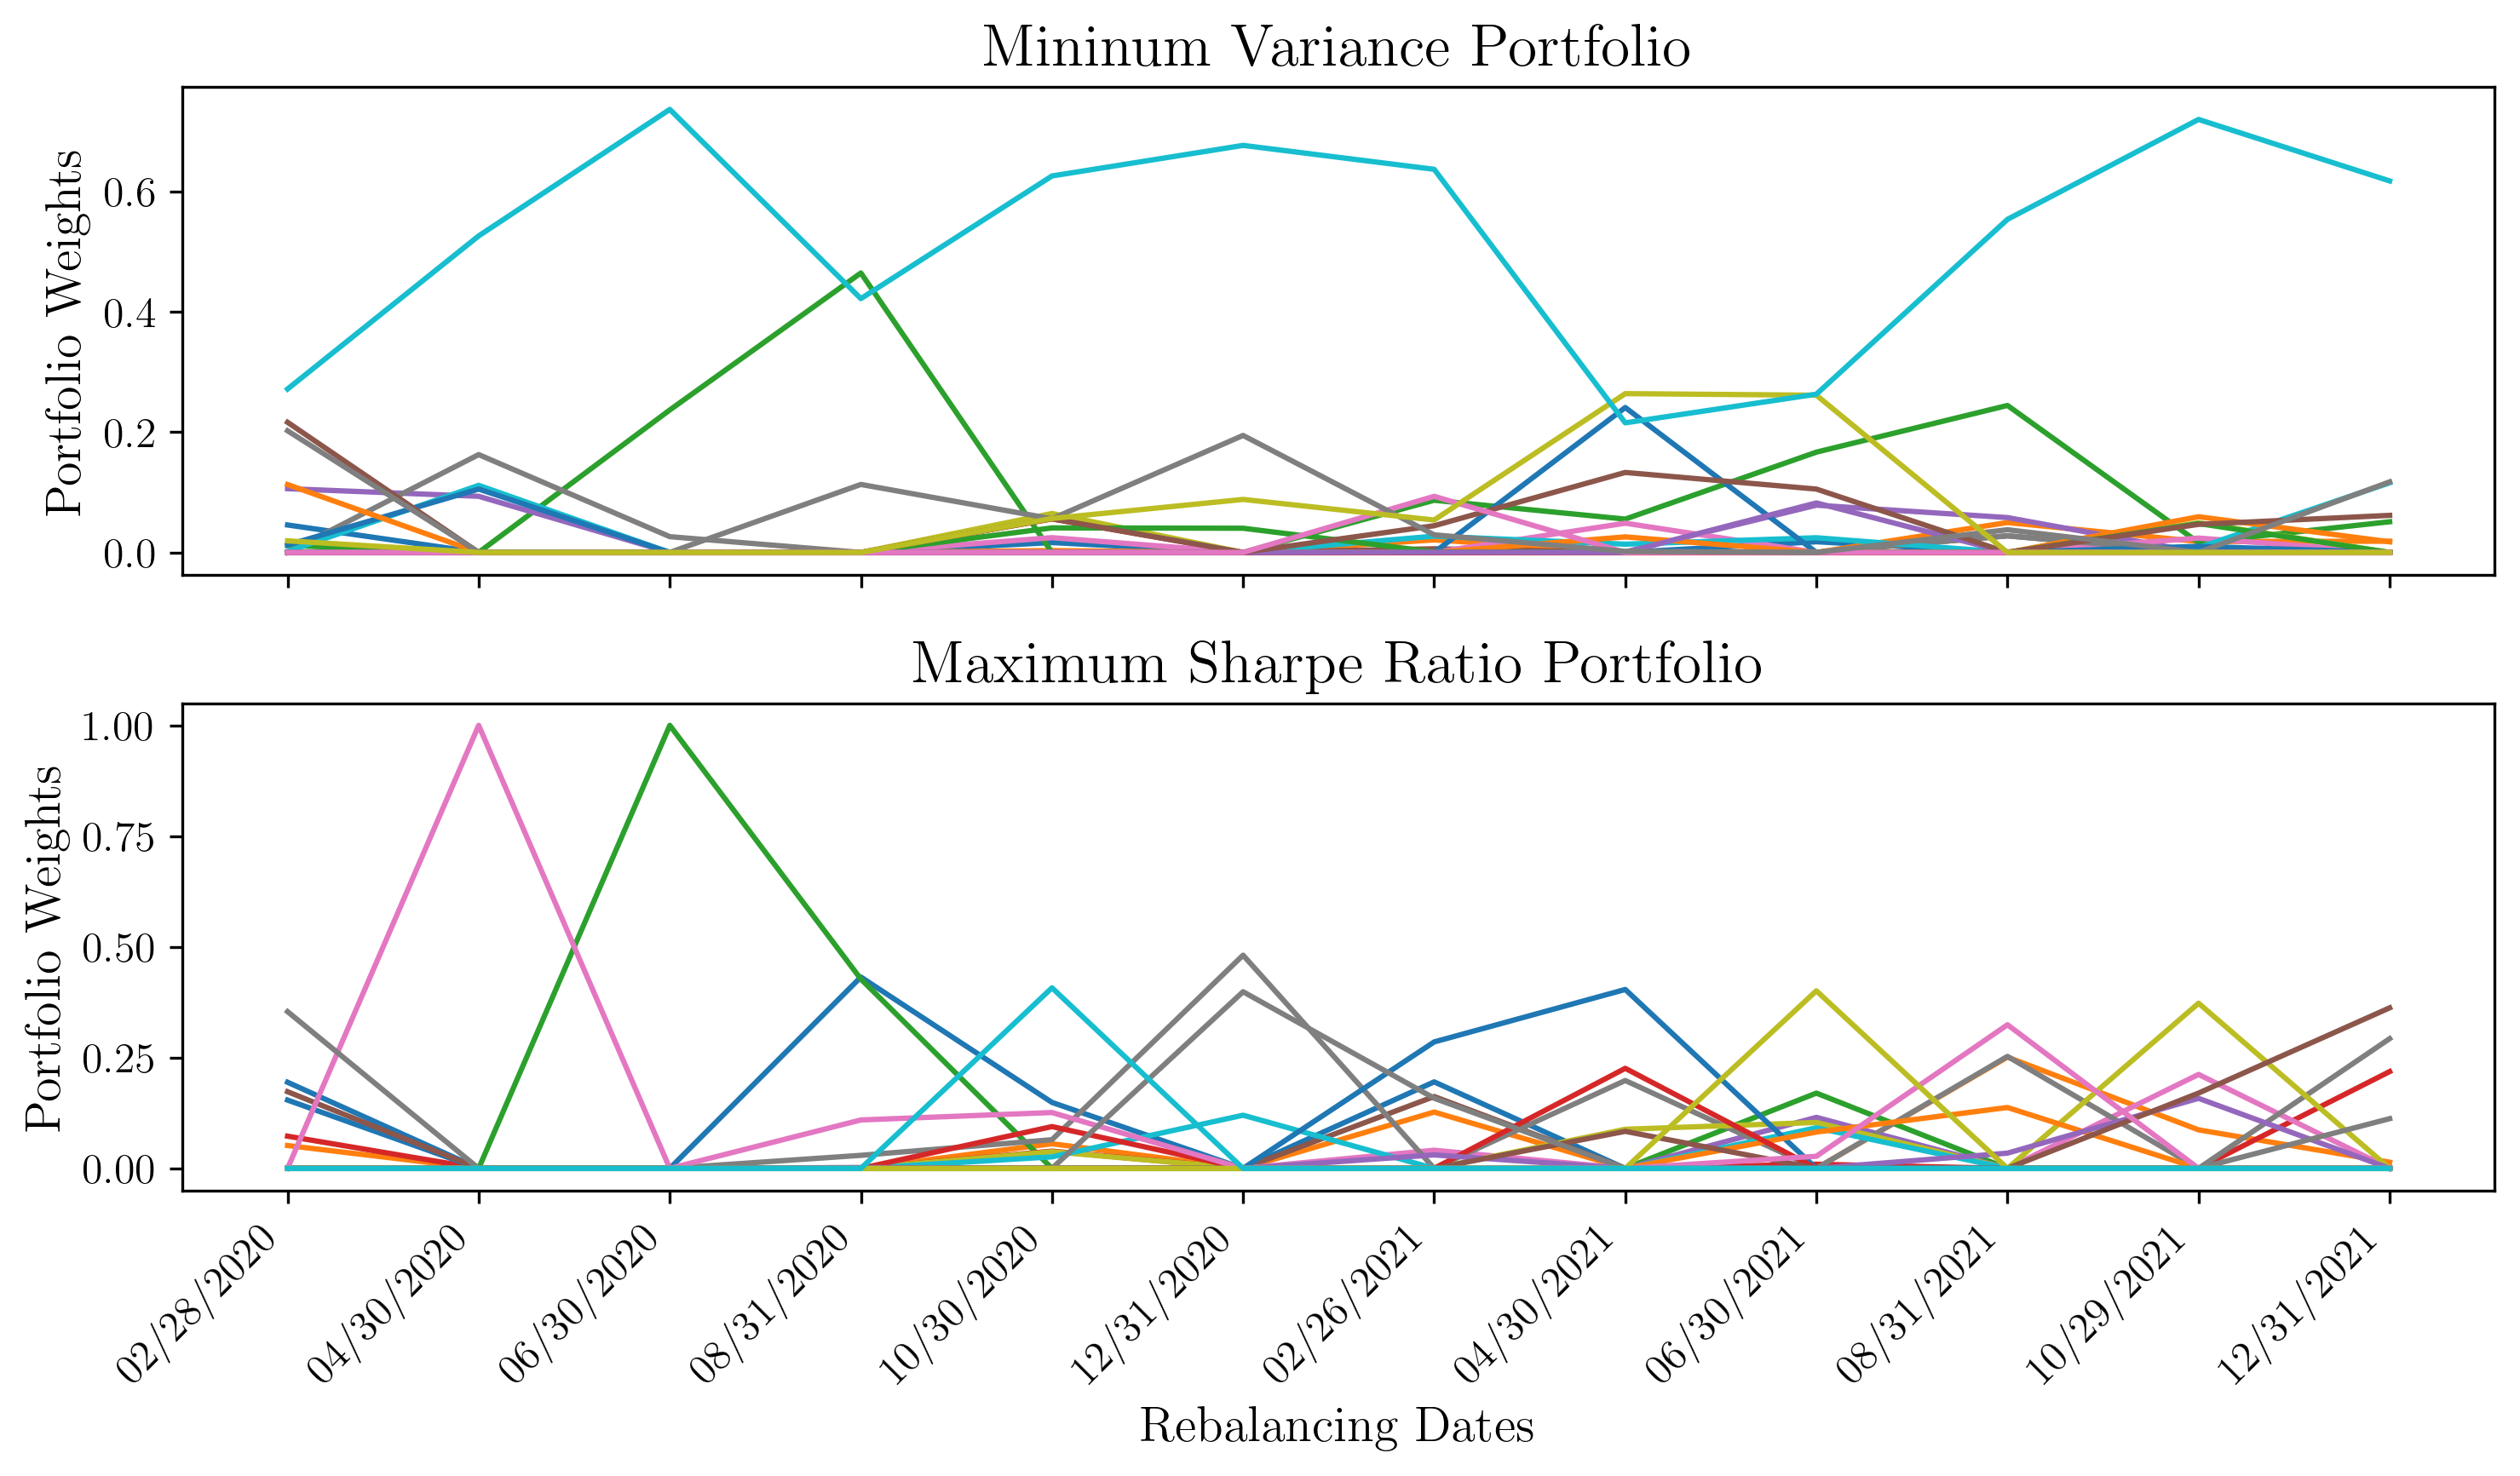

In [17]:
#Create a proper array
# x_3d = np.array([np.stack(row) for row in x])

# Set the figure size and dpi
fig, axs = plt.subplots(2,1, sharex = True, sharey = False, figsize=(10, 6), dpi=300)

for i in range(N):
    axs[0].plot(end_dates, weights[2,:,i])
    axs[1].plot(end_dates, weights[3,:,i])

# Subsample x-axis ticks
# Setting legends
# axs[0].legend(fontsize=14)
# axs[1].legend(fontsize=14)
for ax in axs:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_ylabel("Portfolio Weights")
plt.xlabel("Rebalancing Dates")
axs[0].set_title(strategy_names[2])
axs[1].set_title(strategy_names[3])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
# Specify the directory and filename where you want to save the figure
directory = '/Users/declanbracken/Development/UofT_Projects/MIE_1624/A1/Graphs/'
filename = 'YearsCodingVSalary.png'
full_path = directory + filename
plt.tight_layout()
# Save the figure
# plt.savefig(full_path)
plt.show()